In [1]:
# sci-kit image documentation: 
# https://scikit-image.org/docs/dev/auto_examples/applications/plot_haar_extraction_selection_classification.html
import sys
from time import time

import numpy as np
import matplotlib.pyplot as plt

from dask import delayed

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

from skimage.data import lfw_subset
from skimage.transform import integral_image
from skimage.feature import haar_like_feature
from skimage.feature import haar_like_feature_coord
from skimage.feature import draw_haar_like_feature

# for loading and preprocessing images
import pandas as pd
from PIL import Image
import pathlib

In [2]:
@delayed
def extract_feature_image(img, feature_type, feature_coord=None):
    """Extract the haar feature for the current image"""
    ii = integral_image(img)
    return haar_like_feature(ii, 0, 0, ii.shape[0], ii.shape[1], feature_type=feature_type, feature_coord=feature_coord)

In [3]:
# loading data
DATA_DIR = "facial_expressions/data"
IMAGE_DIR = "facial_expressions/images"
data = pd.read_csv(f'{DATA_DIR}/legend.csv')
data['emotion'] = data['emotion'].str.lower()
# prepping datasets
X_temp = []
# ran into too many files open error: https://stackoverflow.com/questions/29234413/too-many-open-files-error-when-opening-and-loading-images-in-pillow
# find the minimum width and height and I can resize all images to that shape
min_width = 1000
min_height = 1000
for image in data['image']:
    temp = Image.open(IMAGE_DIR + '/' + image)
    keep = temp.copy().convert('L')
    min_width = min(min_width, keep.size[0])
    min_height = min(min_height, keep.size[1])
    X_temp.append(keep)
    temp.close()
images = np.array([np.asarray(image.resize((min_width, min_height))) for image in X_temp])

In [4]:
# computing the features
feature_types = ['type-2-x', 'type-2-y','type-3-x', 'type-3-y','type-4']
# build a computation graph using Dask. This allows the use of multiple
# CPU cores later during the actual computation
X = delayed(extract_feature_image(img, feature_types) for img in images)

# compute the result
t_start = time()
X = np.array(X.compute(scheduler='single-threaded'))
time_full_feature_comp = time() - t_start

# label images with emotion
Y = np.array(data['emotion'])

# spliting data in to training and validation sets
split_factor = 0.8
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=split_factor, stratify=Y)

In [5]:
# extract all possible features
feature_coord, feature_type = haar_like_feature_coord(width=images.shape[2],height=images.shape[1],feature_type=feature_types)

# train an adaboost classifier, tried n_estimators = 50 and n_estimators = 100 but took even longer
# and accuracy rate remained the same
clf = AdaBoostClassifier(n_estimators=30)
t_start = time()
clf.fit(X_train, Y_train)
time_full_train = time() - t_start

In [6]:
# calculate accuracy rate
accuracy_rate = clf.score(X, Y)
training_error = 1-clf.score(X_train, Y_train)
testing_error = 1-clf.score(X_test, Y_test)

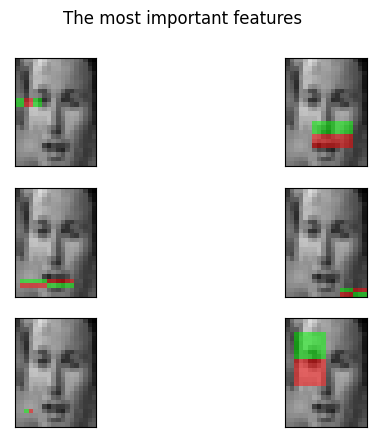

In [7]:
# sort features in order of importance and plot the six most significant
idx_sorted = np.argsort(clf.feature_importances_)[::-1]
fig, axes = plt.subplots(3, 2)
for idx, ax in enumerate(axes.ravel()):
    image = images[10]
    image = draw_haar_like_feature(image, 0, 0,
                                   images.shape[2],
                                   images.shape[1],
                                   [feature_coord[idx_sorted[idx]]])
    ax.imshow(image)
    ax.set_xticks([])
    ax.set_yticks([])

_ = fig.suptitle('The most important features')
plt.show()

In [8]:
summary = ( f'Computing the full feature set took '
            f'{time_full_feature_comp:.3f}s, '
            f'plus {time_full_train:.3f}s training '
            f'with an accuracy rate of {accuracy_rate:.2f}, '
            f'training error of {training_error:.2f}, '
            f'and testing error of {testing_error:.2f}. '
          )
print(summary)
plt.show()

Computing the full feature set took 1134.282s, plus 1995.389s training with an accuracy rate of 0.61, training error of 0.39, and testing error of 0.38. 
